In [1]:
using PyCall
rasterio = pyimport("rasterio");

PyObject <module 'rasterio' from '/Users/simon/anaconda3/envs/sentinel/lib/python3.7/site-packages/rasterio/__init__.py'>

In [2]:
dataset = rasterio.open("/Users/simon/Data/DEM/srtm_38_01/srtm_38_01.tif");

PyObject <open DatasetReader name='/Users/simon/Data/DEM/srtm_38_01/srtm_38_01.tif' mode='r'>

In [4]:
DEM = dataset.read(1);

In [9]:
transform = dataset.get_transform()

6-element Array{Float64,1}:
  5.0                  
  0.0008333333333333334
  0.0                  
 60.0                  
  0.0                  
 -0.0008333333333333334

In [34]:
rows = collect(1:dataset.height);
columns = collect(1:dataset.width);

In [35]:
lon = transform[1] .+rows .*transform[2];
lat  = transform[4] .+columns .*transform[6];

In [36]:
lat_max = 5.666818777336966e+01
lon_max = 8.692126035601964e+00;

In [37]:
lat_min = 5.514243624845066e+01
lon_min = 6.863612098279713e+00;

In [38]:
index1 = lat_min .<lat.< lat_max;
index2 = lon_min .<lon.< lon_max;

In [39]:
test = DEM[index1,index2];
lat = lat[index1]
lon = lon[index2];

In [43]:
using Images
using Statistics

In [44]:
Show_img = abs.(copy(test))
Show_img = Show_img./quantile(reshape(Show_img, :), 0.98);

┌ Info: Recompiling stale cache file /Users/simon/.julia/compiled/v1.0/QuartzImageIO/n8vDP.ji for QuartzImageIO [dca85d43-d64c-5e67-8c65-017450d5d020]
└ @ Base loading.jl:1190


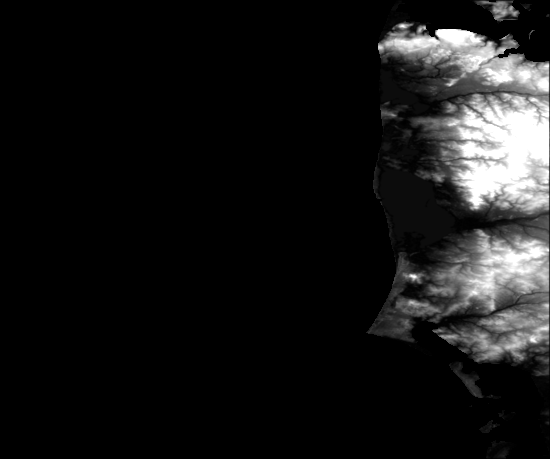

In [45]:
Gray.(Show_img)

In [50]:
size(test)

(1831, 2194)

In [49]:
length(lat)

1831

In [52]:
lat_matrix = Array{Float64}(undef, length(lat), length(lon))
lon_matrix = Array{Float64}(undef,length(lat), length(lon))

for i = 1:length(lat)
    for j = 1:length(lon)
        lat_matrix[i,j] = lat[i]
        lon_matrix[i,j] = lon[j]
    end
end   

In [ ]:
llh = []

In [59]:
lat_matrix = reshape(lat_matrix,:)[test .!= -32768]
lon_matrix = reshape(lon_matrix,:)[test .!= -32768]
test_array = reshape(test,:);[test .!= -32768]

In [69]:
sum(test .!= -32768)

925374

In [63]:
length(test)

4017214

In [61]:
llh = [[lat_matrix[i],lon_matrix[i],test[i]] for i in 1:length(test)]
    

4017214-element Array{Array{Float64,1},1}:
 [56.6675, 6.86417, -32768.0]
 [56.6667, 6.86417, -32768.0]
 [56.6658, 6.86417, -32768.0]
 [56.665, 6.86417, -32768.0] 
 [56.6642, 6.86417, -32768.0]
 [56.6633, 6.86417, -32768.0]
 [56.6625, 6.86417, -32768.0]
 [56.6617, 6.86417, -32768.0]
 [56.6608, 6.86417, -32768.0]
 [56.66, 6.86417, -32768.0]  
 [56.6592, 6.86417, -32768.0]
 [56.6583, 6.86417, -32768.0]
 [56.6575, 6.86417, -32768.0]
 ⋮                           
 [55.1517, 8.69167, 0.0]     
 [55.1508, 8.69167, 0.0]     
 [55.15, 8.69167, 0.0]       
 [55.1492, 8.69167, 0.0]     
 [55.1483, 8.69167, 0.0]     
 [55.1475, 8.69167, 1.0]     
 [55.1467, 8.69167, 0.0]     
 [55.1458, 8.69167, 0.0]     
 [55.145, 8.69167, 0.0]      
 [55.1442, 8.69167, 0.0]     
 [55.1433, 8.69167, 0.0]     
 [55.1425, 8.69167, 0.0]     

In [ ]:
include("llh2sali.jl")

In [ ]:
f = open("ann_path.txt")
path = readlines(f)
sar_parameters = load_s1slc_ann(path[1])

f = open("POD_path.txt")
path = readlines(f)
osv,t_sv = load_pod(path[1],sar_parameters["t_0"]);

In [ ]:
sali = llh2sali(llh, osv, t_sv, sar_parameters);